# Example 3

### xTB descriptors to predict solubility using GNN

This workflow includes:

i) RDKit conformer sampling \
ii) xTB porperty calculations to determine molecular and atomic properties \
iii) Generate a GNN model to predict solubility

#### Steps involved in this example

- Step 1: Import AQME and other python modules, and the required CSV
- Step 2: Run CSEARCH (RDKit) on the CSV
- Step 3: Run xTB calculations using QDESCP
- Step 4: Create the CSV file with descriptors for the GNN model 
- Step 5: Run the gnn.py to get results
  - Step 5a: Load the solubility CSV file and split the data into training, validation and test sets
  - Step 6a: Set up the GNN model
  - Step 7a: Predict solubities of external test set using the GNN model

###  Step 1: Import AQME and other python modules, and the required CSV

In [1]:
import glob
from aqme.csearch import csearch
from aqme.qdescp import qdescp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from gnn_functions import *
from sklearn.metrics import r2_score
import sklearn.metrics as metrics
import tensorflow as tf

file = 'solubility.csv'

[12:19:21] Enabling RDKit 2019.09.3 jupyter extensions
RDKit WARNING: [12:19:21] Enabling RDKit 2019.09.3 jupyter extensions
2022-12-11 12:19:22.342378: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/ASE_ANI/lib::/usr/local/cuda/lib64:/opt/anaconda/envs/DL_CPU/lib/python3.7/site-packages/xtb_6.3.pre1/lib64/:/usr/local/intel64_lin/
2022-12-11 12:19:22.342458: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


###  Step 2: Run CSEARCH (RDKit) on the CSV

In [2]:
csearch(program='rdkit',input=file,ewin_csearch=1)

True
AQME v 1.4.0 2022/12/07 13:32:55 
Citation: AQME v 1.4.0, Alegre-Requena, J. V.; Sowndarya, S.; Perez-Soto, R.; Alturaifi, T. M.; Paton, R. S., 2022. https://github.com/jvalegre/aqme



Starting CSEARCH with 1128 job(s) (SDF, XYZ, CSV, etc. files might contain multiple jobs/structures inside)



   ----- mol_1 -----


o  Applying filters to initial conformers


   ----- mol_2 -----


o  Applying filters to initial conformers


   ----- mol_3 -----


o  Applying filters to initial conformers


   ----- mol_4 -----


o  Applying filters to initial conformers


   ----- mol_5 -----


o  Applying filters to initial conformers


   ----- mol_6 -----


o  Applying filters to initial conformers


   ----- mol_7 -----


o  Applying filters to initial conformers


   ----- mol_8 -----


o  Applying filters to initial conformers


   ----- mol_9 -----


o  Applying filters to initial conformers


   ----- mol_10 -----


o  Applying filters to initial conformers


   ----- mol_11 -----


o  

### Step 3 : Run xTB calculations using QDESCP

In [ ]:
sdf_rdkit_files = glob.glob(f'CSEARCH/*.sdf')
qdescp(files=sdf_rdkit_files, boltz=True, program='xtb')

#or run with python script on terminal if the number of molecules are large

#python run_qdescp.py

### Step 4 : Create the CSV file with descriptors for the GNN model 

In [8]:
data =  pd.read_csv(file)
drop = ['mol_556','mol_641'] # taking out as QDESCP did not work for these molecules!
data = data[~data.code_name.isin(drop)]
data['xtbjson'] = data['code_name'].apply(lambda x: 'QDESCP/boltz/{}_rdkit_boltz.json'.format(x))
data.to_csv('solubility_xtb.csv',index=False)

### The following steps can be done using a script as shown or run in the notebook itself

###  Step 5: Run the gnn.py to get results

##### We had done it by using the gnn.py script for our result of R2=0.8 

In [9]:
#python gnn.py

###  Step 5a: Load the solubility CSV file and split the data into training, validation and test sets

In [19]:
sol = pd.read_csv('solubility_xtb.csv')
select_pts, remaining_pts = kennardstone(sol[['Minimum Degree',
       'Molecular Weight', 'Number of H-Bond Donors', 'Number of Rings',
       'Number of Rotatable Bonds', 'Polar Surface Area']])
train = pd.DataFrame(sol, index=select_pts).dropna().reset_index(drop=True)[['smiles','xtbjson']]
test = pd.DataFrame(sol, index=remaining_pts).dropna().reset_index(drop=True)[['smiles','xtbjson']]
test, valid = np.split(test[['smiles','xtbjson']].sample(frac=1., random_state=41), [50])

###  Step 5b: Set up the GNN dataset and model

In [20]:
train_dataset, valid_dataset, test_dataset = gnn_data(valid, test, train, sol)
inputs, outputs = next(train_dataset.as_numpy_iterator())

In [21]:
model = gnn_model()
model.compile(loss='mae', optimizer=tf.keras.optimizers.Adam(1E-3))
model.fit(train_dataset, validation_data=valid_dataset, epochs=500)

Epoch 1/500


/apps/conda/svss/envs/bm/lib/python3.7/site-packages/tensorflow/python/keras/engine/functional.py:595: UserWarning: Input dict contained keys ['bond_xtb', 'bond_indices', 'bond_atom_indices', 'atom_indices'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


1/1 [==============================] - 28s 28s/step - loss: 52.6034 - val_loss: 411.7214
Epoch 2/500
1/1 [==============================] - 10s 10s/step - loss: 511.6107 - val_loss: 869.9122
Epoch 3/500
1/1 [==============================] - 9s 9s/step - loss: 1046.6083 - val_loss: 26.6443
Epoch 4/500
1/1 [==============================] - 9s 9s/step - loss: 23.9380 - val_loss: 46.1852
Epoch 5/500
1/1 [==============================] - 9s 9s/step - loss: 48.3774 - val_loss: 113.6954
Epoch 6/500
1/1 [==============================] - 10s 10s/step - loss: 126.5228 - val_loss: 110.7359
Epoch 7/500
1/1 [==============================] - 11s 11s/step - loss: 109.9539 - val_loss: 460.3235
Epoch 8/500
1/1 [==============================] - 10s 10s/step - loss: 540.7497 - val_loss: 106.6718
Epoch 9/500
1/1 [==============================] - 10s 10s/step - loss: 130.9846 - val_loss: 336.9707
Epoch 10/500
1/1 [==============================] - 9s 9s/step - loss: 383.6578 - val_loss: 87.0062
Epoc

### Step 5c: Predict solubities of external test set using the GNN model

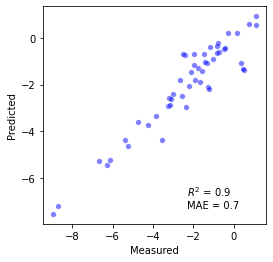

In [24]:
# Predict solubility of the external test set
test_predictions = model.predict(test_dataset)
test_db_values = sol.set_index('smiles').reindex(test.smiles)['measured log solubility in mols per litre'].values

# Plot the results
fig = plt.subplots(figsize=(4,4))

ax1 = sns.scatterplot(x=test_db_values,y=test_predictions.flatten(),s=30,marker='o',color='b',alpha=0.5)
ax1.set_xlabel(r'Measured',fontsize=10)
ax1.set_ylabel(r'Predicted',fontsize=10)

mae = metrics.mean_absolute_error(test_db_values,test_predictions.flatten())
r2 = metrics.r2_score(test_db_values,test_predictions.flatten())

plt.annotate(f"$R^2$ = {round(r2,1)} \nMAE = {round(mae,1)} ", xy=(-2.3, -7.3), fontsize=10)
plt.savefig('solubility-gnn.jpg',dpi=400)
plt.show()